# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
pd.set_option('display.max_colwidth', None)

In [24]:
# Decribing the data that has been provided using Pandas functions
# Save to df
data=pd.read_csv('data/vehicles.csv')

# Shape and preview
print('Vehicles DataFrame Shape :',data.shape)
pd.set_option('display.max_columns', None)
data.head()

Vehicles DataFrame Shape : (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [25]:
# Use Dataframe describe/view some basic statistical details like percentile, mean, std etc. of the dataset
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [26]:
# Exploring the data, lets start by describing the dataframe to get a list of provided attributes/features
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [27]:
#Check the number of Null Columns
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [28]:
# We start the data preparation by taking a copy of the loaded dataset and dropping null rows
data_copy = data.copy().dropna()
data_copy.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


In [29]:
#Let's print the number of records
data_copy.shape

(34868, 18)

In [ ]:
# Reviewing the records, we can state that id and VIN are not useful for predicting the car price
# Attributes region and state are also duplicates. We can remove one for now. 
# Removing region as the unique count shows some region with 1 car

In [30]:
# Drop the following columns
data_copy.drop('id', axis=1, inplace=True)
data_copy.drop('VIN', axis=1, inplace=True)
data_copy.drop('region', axis=1, inplace=True)
data_copy

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
126,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white,al
127,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white,al
128,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white,al
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy
426833,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy


In [31]:
#Check on which columns are nulls
data_copy.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [32]:
s = data_copy.eq(0).any()
s
# we can see that there are some records with zero values


price            True
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

In [14]:
# Get the count of Zeros in column 'price' 
count = (data_copy['price'] == 0).sum()
print('Count of zeros in Column  price : ', count)
# Get the count of Zeros in column 'odometer' 
count = (data_copy['odometer'] == 0).sum()
print('Count of zeros in Column  odometer : ', count)

# Removing records with zero for Odometer and Prices
# Remove rows with all 0s in a Dataframe
data_copy.drop(data_copy[data_copy['price'] == 0].index, inplace = True)
data_copy.drop(data_copy[data_copy['odometer'] == 0].index, inplace = True)
data_copy


Count of zeros in Column  price :  2372
Count of zeros in Column  odometer :  81


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
268,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,rwd,compact,convertible,white,al
337,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,fwd,full-size,truck,white,al
338,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,4wd,full-size,truck,black,wy
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy


In [33]:
#remove column which has lot of unique data
# Remove these features above from the datasets state, paint_color, manufacturer, model, cylinders,
# type, transmission and title_status

data_copy.drop(['state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'title_status'], axis=1,  inplace=True)
data_copy.head(5)


,price,year,condition,fuel,odometer,drive,size
126,0,2018.0,like new,gas,68472.0,rwd,full-size
127,0,2019.0,like new,gas,69125.0,rwd,full-size
128,0,2018.0,like new,gas,66555.0,rwd,full-size
215,4000,2002.0,excellent,gas,155000.0,fwd,compact
219,2500,1995.0,fair,gas,110661.0,rwd,mid-size


In [34]:
#create categorical variables and drop some variables
model_data_df=pd.get_dummies(data_copy, columns=["condition","fuel","size", "drive"])
model_data_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
126,0,2018.0,68472.0,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True
127,0,2019.0,69125.0,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True
128,0,2018.0,66555.0,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True
215,4000,2002.0,155000.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False
219,2500,1995.0,110661.0,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True


In [35]:
model_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34868 entries, 126 to 426836
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                34868 non-null  int64  
 1   year                 34868 non-null  float64
 2   odometer             34868 non-null  float64
 3   condition_excellent  34868 non-null  bool   
 4   condition_fair       34868 non-null  bool   
 5   condition_good       34868 non-null  bool   
 6   condition_like new   34868 non-null  bool   
 7   condition_new        34868 non-null  bool   
 8   condition_salvage    34868 non-null  bool   
 9   fuel_diesel          34868 non-null  bool   
 10  fuel_electric        34868 non-null  bool   
 11  fuel_gas             34868 non-null  bool   
 12  fuel_hybrid          34868 non-null  bool   
 13  fuel_other           34868 non-null  bool   
 14  size_compact         34868 non-null  bool   
 15  size_full-size       34868 non-null  b

In [36]:
#Let's look at the correlation for the final dataset
model_data_df.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
price,1.000000,0.254059,-0.199988,-0.052904,-0.101943,-0.026001,0.147712,0.053054,-0.026545,0.387653,0.020846,-0.349105,-0.037609,-0.008114,-0.176885,0.301471,-0.186239,-0.059600,0.257766,-0.328728,0.058467
year,0.254059,1.000000,-0.219942,0.091372,-0.166933,-0.149387,0.125173,0.043993,-0.019995,0.026328,0.029395,-0.034489,0.019517,-0.016749,0.010835,-0.006571,0.003399,-0.013108,0.132187,0.032796,-0.199132
odometer,-0.199988,-0.219942,1.000000,-0.033674,0.117981,0.091197,-0.114376,-0.044159,0.028526,0.044920,-0.027503,-0.037763,-0.001255,0.007916,-0.054236,0.069238,-0.033886,-0.011022,0.017508,-0.004406,-0.016420
condition_excellent,-0.052904,0.091372,-0.033674,1.000000,-0.139234,-0.745119,-0.415100,-0.090377,-0.037416,-0.027189,-0.013970,0.022460,0.012428,0.004964,0.066811,-0.101761,0.050704,0.043896,0.060001,0.023832,-0.100566
condition_fair,-0.101943,-0.166933,0.117981,-0.139234,1.000000,-0.076593,-0.042669,-0.009290,-0.003846,-0.016946,-0.005701,0.015399,0.000007,0.012435,0.011911,-0.019702,0.015298,-0.007401,-0.024706,0.015451,0.012664
condition_good,-0.026001,-0.149387,0.091197,-0.745119,-0.076593,1.000000,-0.228347,-0.049716,-0.020582,0.045208,-0.013240,-0.028276,-0.030827,-0.004804,-0.076664,0.118143,-0.065422,-0.031178,-0.041339,-0.053538,0.111519
condition_like new,0.147712,0.125173,-0.114376,-0.415100,-0.042669,-0.228347,1.000000,-0.027697,-0.011466,-0.013765,0.044008,-0.000241,0.018203,-0.004823,-0.001183,-0.000407,0.008282,-0.023403,-0.028393,0.032271,-0.001959
condition_new,0.053054,0.043993,-0.044159,-0.090377,-0.009290,-0.049716,-0.027697,1.000000,-0.002496,-0.006733,-0.003700,-0.002077,0.025235,-0.002354,0.005403,-0.006387,0.000563,0.008641,0.014664,0.003495,-0.021927
condition_salvage,-0.026545,-0.019995,0.028526,-0.037416,-0.003846,-0.020582,-0.011466,-0.002496,1.000000,-0.006722,-0.001532,0.004930,0.004567,-0.000974,0.010603,-0.012535,0.005512,0.002214,-0.003760,0.007108,-0.003484
fuel_diesel,0.387653,0.026328,0.044920,-0.027189,-0.016946,0.045208,-0.013765,-0.006733,-0.006722,1.000000,-0.014672,-0.913747,-0.034200,-0.009331,-0.106362,0.242101,-0.176850,-0.041510,0.177003,-0.189203,-0.001412


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

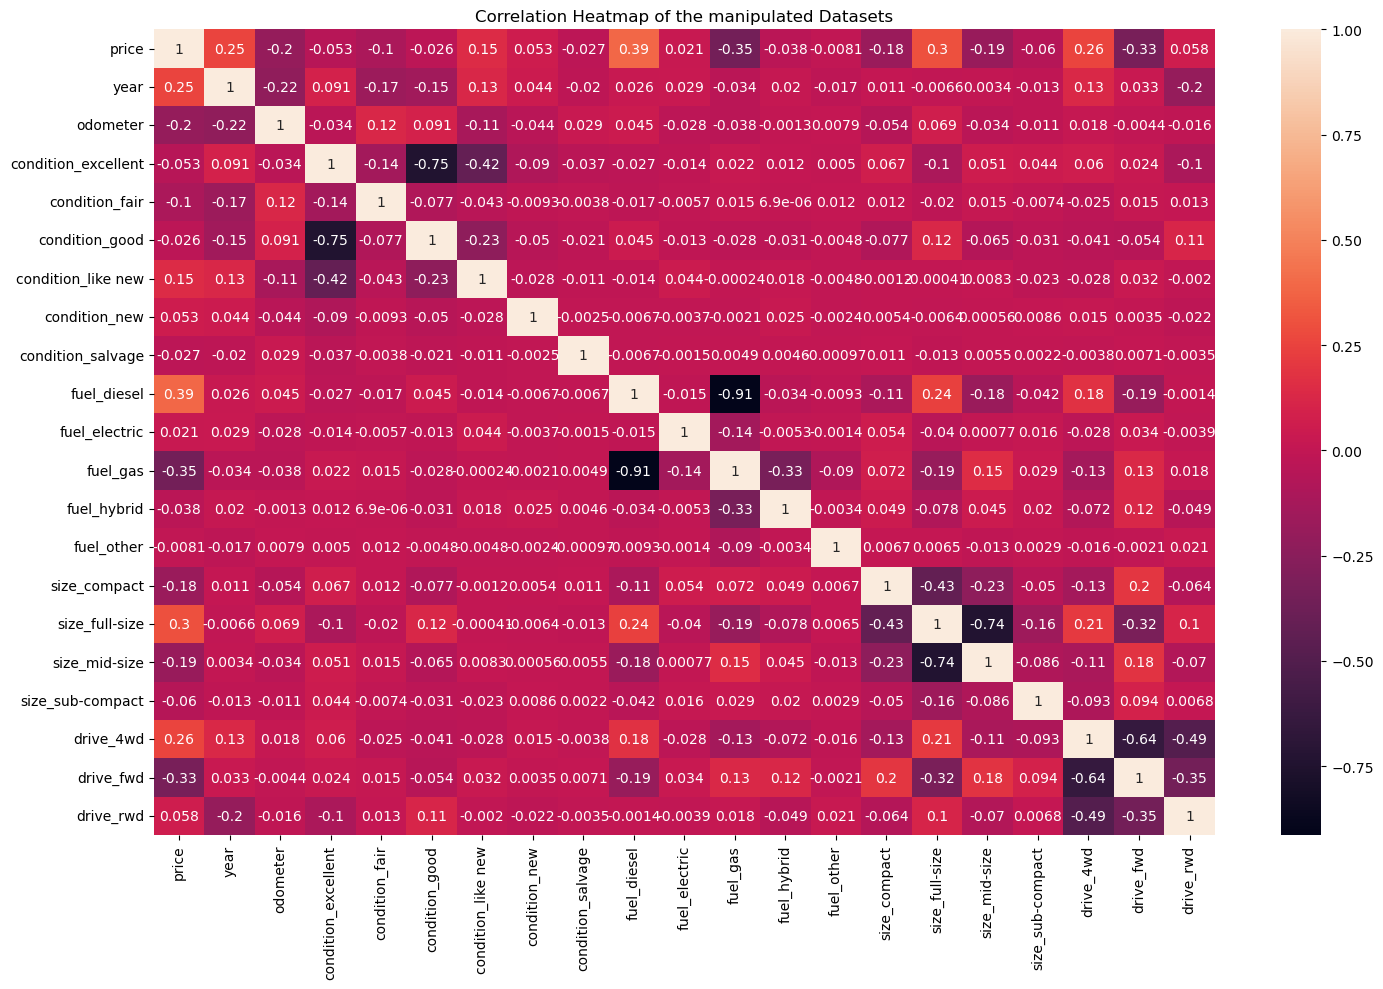

In [37]:
# Now lets look at the heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(model_data_df.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

Looking at price, most of the values are negative, the only positive ones are year, condition_like new, fuel_diesel, size_full-size and drive_4wd. The strongest correlation to price is fuel_diesel. Although they are positive numbers, they are not strong correlations that should be considered for removal as the value is less than 0.85

In [38]:

## split the data to training and test sets, 70/30 split ratio 
X = model_data_df.drop(['price'], axis = 1)
y = model_data_df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [39]:

model=LinearRegression(fit_intercept=False)

In [40]:
# With model created,  fit the model using the manipulated datasets
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [41]:

print("Coefficient of the model: ",model.coef_)
print("Intercept of the model: ", model.intercept_)

Coefficient of the model:  [ 3.67343483e+02 -1.76865712e-02 -1.26966027e+05 -1.30824236e+05
 -1.27033642e+05 -1.21753808e+05 -1.18486737e+05 -1.32043025e+05
 -1.41395576e+05 -1.50010838e+05 -1.55917319e+05 -1.54204247e+05
 -1.55579495e+05 -1.91663634e+05 -1.85837671e+05 -1.89831749e+05
 -1.89774421e+05 -2.50162032e+05 -2.56833530e+05 -2.50111913e+05]
Intercept of the model:  0.0


In [42]:

# get the cofficients
[(col, coef) for col, coef in zip (X_train.columns, model.coef_)]

[('year', 367.34348284970923),
 ('odometer', -0.017686571164302833),
 ('condition_excellent', -126966.02732406203),
 ('condition_fair', -130824.23558735319),
 ('condition_good', -127033.64179276158),
 ('condition_like new', -121753.80779161278),
 ('condition_new', -118486.73737129346),
 ('condition_salvage', -132043.02547673197),
 ('fuel_diesel', -141395.5763993421),
 ('fuel_electric', -150010.83795152407),
 ('fuel_gas', -155917.31864663603),
 ('fuel_hybrid', -154204.24744079937),
 ('fuel_other', -155579.49490549785),
 ('size_compact', -191663.63395868463),
 ('size_full-size', -185837.67099373328),
 ('size_mid-size', -189831.74924618503),
 ('size_sub-compact', -189774.42114519372),
 ('drive_4wd', -250162.03211699985),
 ('drive_fwd', -256833.53027717545),
 ('drive_rwd', -250111.91294965585)]

In [45]:
#Let compute the predictions for the entire set of inputs
train_predictions=model.predict(X_train)
train_predictions
#Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_train,train_predictions)), 2))

# Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ",  round(score*100, 2))
print("RMSE:     ",np.sqrt(mean_squared_error(y_train,train_predictions)))

# Using the model to make predictions of Price on the test set:
test_predictions=model.predict(X_test)

Accuracy:  34.34
RMSE:      10911.96
Accuracy:  34.34
RMSE:      10911.958585842649


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [47]:

# Run Regression using Odometer and Year for Price Prediction
X1 = model_data_df[['odometer', 'year']]
y1 = model_data_df.price
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 0)
model1=LinearRegression(fit_intercept=False)
model1.fit(X1_train, y1_train)
print("Coefficient of the model: ",model1.coef_)
print("Intercept of the model: ", model1.intercept_)

# get the cofficients
[(col, coef) for col, coef in zip (X1_train.columns, model1.coef_)]

#Let compute the predictions for the entire set of inputs
train1_predictions=model1.predict(X1_train)
train1_predictions


#Compute Accuracy and RMSE to training model
score1 = model1.score(X1_train, y1_train)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y1_train,train1_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test1_predictions=model1.predict(X1_test)

# Compute Accuracy and RMSE to test model
score1 = model1.score(X1_test, y1_test)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,test_predictions)), 2))

Coefficient of the model:  [-0.02202111  9.08718218]
Intercept of the model:  0.0
Accuracy:  3.52
RMSE:      13227.38
Accuracy:  5.36
RMSE:      10669.4


In [48]:
# Use a loop to build models of degree 1 through 7 on X_train with y1_train as the target. 
# Evaluate the mean_squared_error on the training data and the testing data and save these values as the lists train_mses and test_mses respectively. 
# Determine the model complexity that minimizes the mean_squared_error on the test  data, and assign this as an integer to best_model_complexity below.

train1_mses = []
test1_mses = []
best_model_complexity1 = ''

for i in range(1, 7):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                    ('linreg', LinearRegression())])
    pipe.fit(X1_train, y1_train)
    train1_preds = pipe.predict(X1_train)
    test1_preds = pipe.predict(X1_test)
    train1_mses.append(mean_squared_error(y1_train, train1_preds))
    test1_mses.append(mean_squared_error(y1_test, test1_preds))
    
best_model_complexity1 = test1_mses.index(min(test1_mses)) + 1

print(len(train1_mses))
print(np.round(train1_mses, 2))
print(len(test1_mses))
print(np.round(test1_mses, 2))
print(best_model_complexity1)

6
[1.67030773e+08 1.49756970e+08 1.56648312e+08 1.55044148e+08
 1.59010140e+08 1.79303137e+08]
6
[1.62546535e+08 1.49552058e+08 1.54540719e+08 1.53658745e+08
 1.59006726e+08 1.85115405e+08]
2


In [50]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

modelR = Ridge(alpha=1e-2).fit(X1_train, y1_train)
modelR.score(X1_test, y1_test)  

0.10063988005651858

In [51]:
#  permutation_importance function to probe which features are most predictive
r = permutation_importance(modelR, X1_test, y1_test, n_repeats=30, random_state=0)

In [52]:
# mean values for permutation_importance
perm_df = pd.Series(r.importances_mean, index=X1_test.columns).sort_values(ascending=False)
perm_df

year        0.107361
odometer    0.037905
dtype: float64

Text(0.5, 0, 'Dataset Columns')

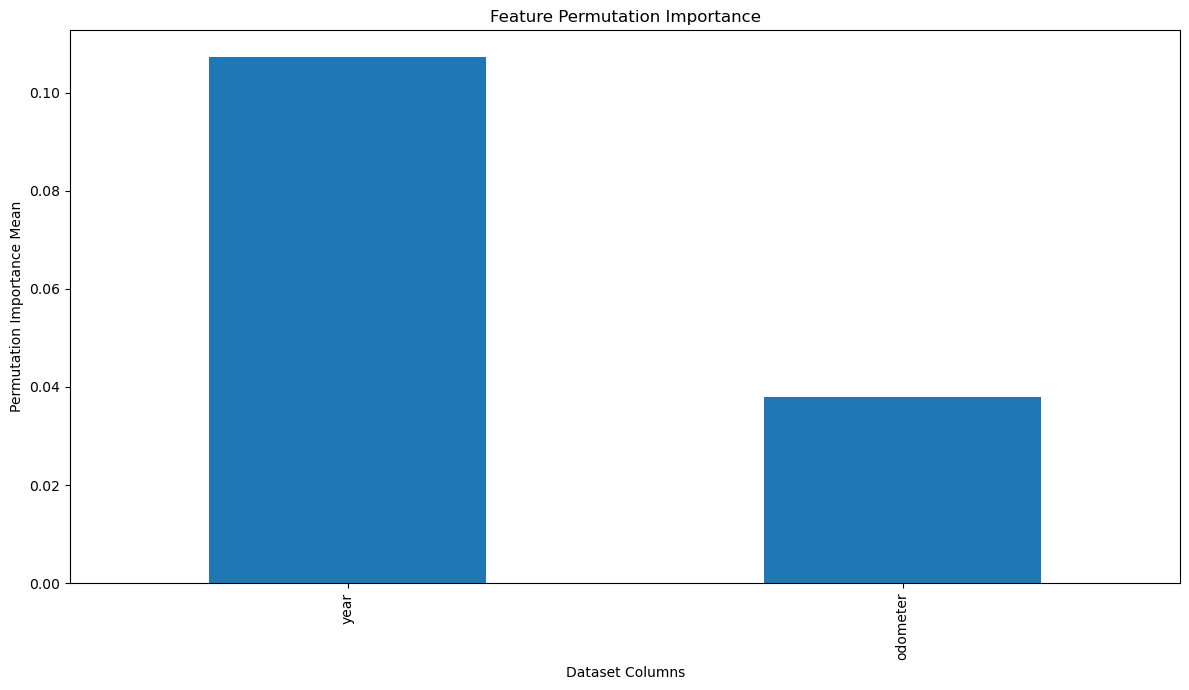

In [53]:
# Bar chart plot of the mean values for permutation_importance
plt.figure(figsize =(12, 7))
perm_df.plot.bar(x=X1_test.columns, y=r.importances_mean)

plt.title("Feature Permutation Importance")
plt.ylabel("Permutation Importance Mean")
plt.xlabel("Dataset Columns")

In [54]:
# Let start by copying the data
new_car_data_df = model_data_df.copy()
new_car_data_df

# Remove records with Odometer and Price less than 5000
new_car_data_df1 = new_car_data_df.query("odometer > 5000 and price > 5000")
new_car_data_df1

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
346,98900,2001.0,20187.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
355,9400,2008.0,129473.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True
364,7300,2007.0,181000.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,146795.0,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False
426788,12995,2016.0,61127.0,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False
426792,32999,2014.0,154642.0,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
426793,15999,2018.0,36465.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

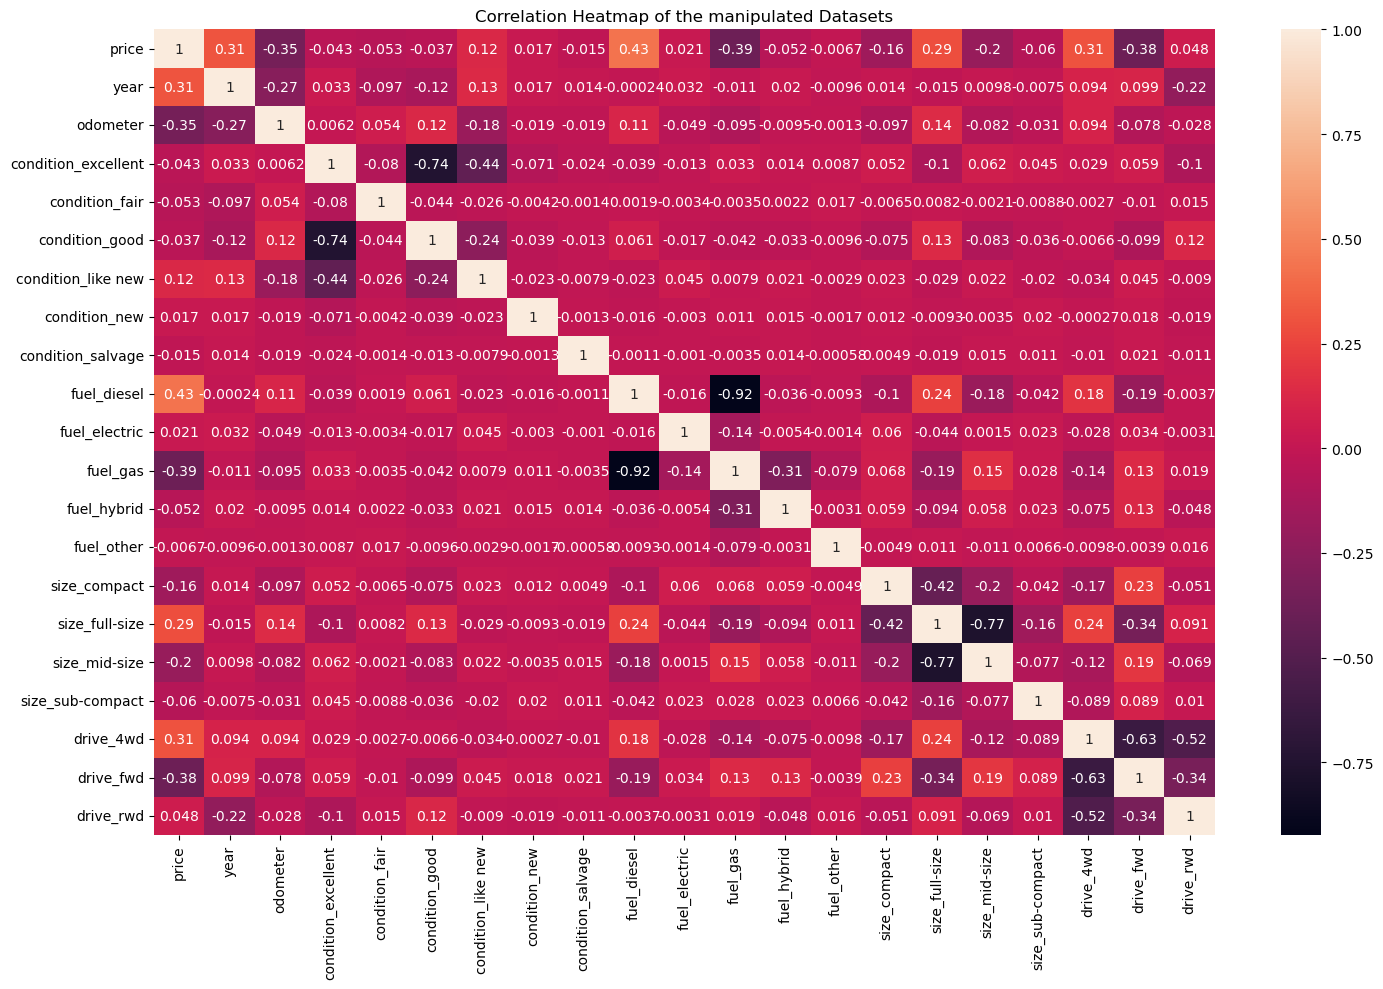

In [55]:
# Now lets look at the heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(new_car_data_df1.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

In [56]:
# Run Regression using Odometer and Year for Price Prediction
X2 = new_car_data_df1[['odometer', 'year']]
y2 = new_car_data_df1.price
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 0)
model2=LinearRegression(fit_intercept=False)
model2.fit(X2_train, y2_train)
print("Coefficient of the model: ",model2.coef_)
print("Intercept of the model: ", model2.intercept_)

Coefficient of the model:  [-0.07321818 13.17246703]
Intercept of the model:  0.0


In [57]:
# Using OneHotEncoder and permutation importance to determine the main features that impact used car prices
data_copy1 = data_copy.query("odometer > 5000 and price > 5000")
data_copy1.head()

,price,year,condition,fuel,odometer,drive,size
268,9000,2008.0,excellent,gas,56700.0,rwd,compact
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size
346,98900,2001.0,good,gas,20187.0,rwd,mid-size
355,9400,2008.0,good,gas,129473.0,rwd,full-size
364,7300,2007.0,good,gas,181000.0,fwd,mid-size


In [59]:
data_copy1.describe()

,price,year,odometer
count,27816.000000,27816.000000,2.781600e+04
mean,18910.265926,2011.626043,1.047101e+05
std,12557.334892,6.615416,5.932711e+04
min,5100.000000,1927.000000,5.011000e+03
25%,9500.000000,2009.000000,6.691875e+04
50%,14995.000000,2013.000000,1.021260e+05
75%,24990.000000,2016.000000,1.369650e+05
max,150000.000000,2021.000000,1.710000e+06


In [58]:
X5 = data_copy1.drop(columns='price')
y5 = data_copy1['price']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.3, random_state = 0)

In [60]:
# Use a loop to build models of degree 1 through 7 on X_train with y1_train as the target. 
# Evaluate the mean_squared_error on the training data and the testing data and save these values as the lists train_mses and test_mses respectively. 
# Determine the model complexity that minimizes the mean_squared_error on the test  data, and assign this as an integer to best_model_complexity below.
# Also using OneHotEncoder as oppose to get_dummies to see if there are any difference in results
feature_cols = ['odometer', 'year']
train_mses = []
test_mses = []

best_mse = np.inf
best_pipe = None

for i in range (1, 10):
    col_transformer = make_column_transformer ((OneHotEncoder(), ['condition','fuel','drive','size']),
                                              (PolynomialFeatures(degree = i, include_bias=False), feature_cols), 
                                               remainder='passthrough')
    pipe = Pipeline([
        ('col_transformer', col_transformer),
        ('model', LinearRegression())
    ])
    
    pipe.fit(X5_train, y5_train)

    
    train_preds = pipe.predict(X5_train)
    test_preds = pipe.predict(X5_test)
    train_mses.append(mean_squared_error(train_preds, y5_train))
    test_mse = mean_squared_error(test_preds, y5_test)
    if test_mse < best_mse:
        best_mse = test_mse
        best_pipe = pipe
    test_mses.append(test_mse)
     
best_model_complexity = test_mses.index(min(test_mses)) + 1

print(len(train_mses))
print(np.round(train_mses, 2))
print(len(test_mses))
print(np.round(test_mses, 2))
print(best_model_complexity)

9
[7.21384200e+07 5.83762339e+07 1.12537522e+08 1.17756721e+08
 1.16665871e+08 1.25346937e+08 1.39753130e+08 1.46887645e+08
 1.52249860e+08]
9
[7.44246068e+07 6.12120362e+07 1.20019447e+08 1.25328776e+08
 1.32033822e+08 1.34442696e+08 1.80118245e+08 2.30635961e+08
 3.00864452e+08]
2


The Complexity that minimized Test Error was: 2
The minimal MSE was: 61212036.2097872


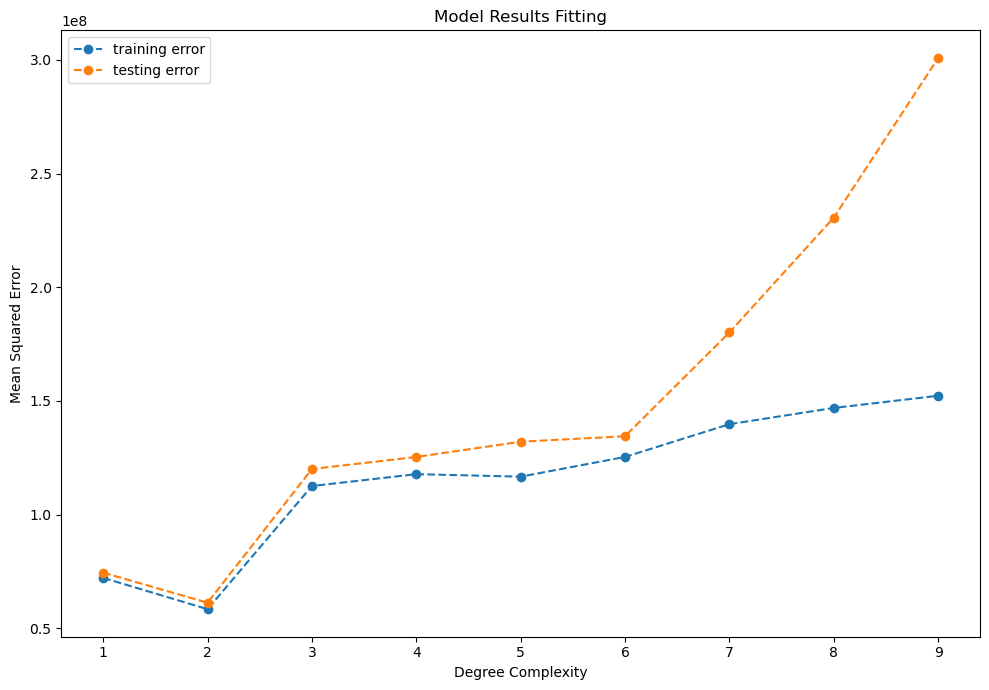

In [61]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The minimal MSE was: {min(test_mses)}')
plt.figure(figsize=(10, 7))
plt.plot(range(1, 10), train_mses, '--o', label = 'training error')
plt.plot(range(1, 10), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 10), range(1, 10))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.title('Model Results Fitting')
plt.legend();

In [63]:
# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X6 = new_car_data_df1[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y6 = new_car_data_df1.price
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.3, random_state = 0)
model6=LinearRegression(fit_intercept=False)
model6.fit(X6_train, y6_train)
print("Coefficient of the model: ",model6.coef_)
print("Intercept of the model: ", model6.intercept_)

#Let compute the predictions for the entire set of inputs
train6_predictions=model6.predict(X6_train)

#Compute Accuracy and RMSE to training model
score6 = model6.score(X6_train, y6_train)
print("Accuracy: ", round(score6*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y6_train,train6_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test6_predictions=model6.predict(X6_test)

# Compute Accuracy and RMSE to test model
score6 = model6.score(X6_test, y6_test)
print("Accuracy: ", round(score6*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y6_test,test6_predictions)), 2))

Coefficient of the model:  [-9.29055281e-02  1.03483761e+01  1.63674361e+04  5.73780578e+03
  5.37707748e+03]
Intercept of the model:  0.0
Accuracy:  45.26
RMSE:      9226.0
Accuracy:  46.88
RMSE:      9298.39


In [64]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

model6R = Ridge(alpha=1e-2).fit(X6_train, y6_train)
model6R.score(X6_test, y6_test)

0.49799687562124473

In [65]:
#  permutation_importance function to probe which features are most predictive
r6 = permutation_importance(model6R, X6_test, y6_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df6 = pd.Series(r6.importances_mean, index=X6_test.columns).sort_values(ascending=False)
perm_df6

fuel_diesel       0.306407
odometer          0.299662
drive_4wd         0.086750
size_full-size    0.086642
year              0.072825
dtype: float64

Text(0.5, 0, 'Car Features')

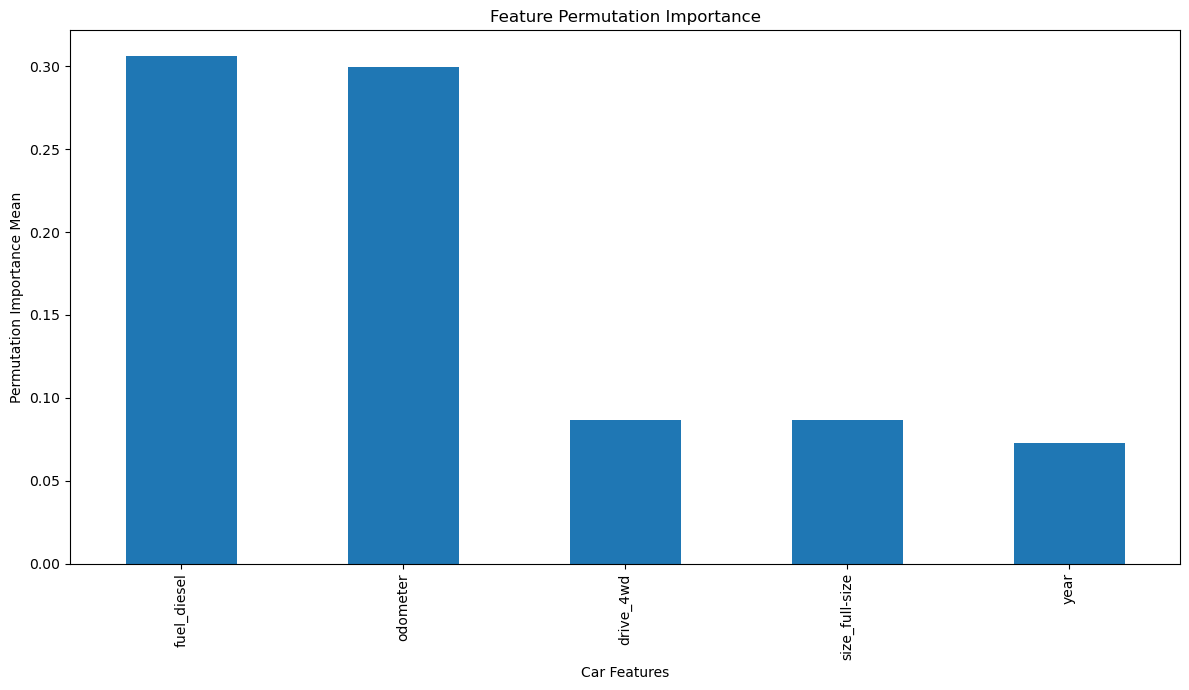

In [66]:
# Bar chart plot of the mean values for permutation_importance
plt.figure(figsize =(12, 7))
perm_df6.plot.bar(x=X6_test.columns, y=r6.importances_mean)

plt.title("Feature Permutation Importance")
plt.ylabel("Permutation Importance Mean")
plt.xlabel("Car Features")

In [67]:
# Create a new dataframe with used cars from 1990 onwards
new_car_data_1990_df = new_car_data_df1.query("year > 1990")
new_car_data_1990_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
268,9000,2008.0,56700.0,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True
337,8950,2011.0,164000.0,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
346,98900,2001.0,20187.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
355,9400,2008.0,129473.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True
364,7300,2007.0,181000.0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False


In [68]:
# Number of the records in the dataset
new_car_data_1990_df.shape

(27444, 21)

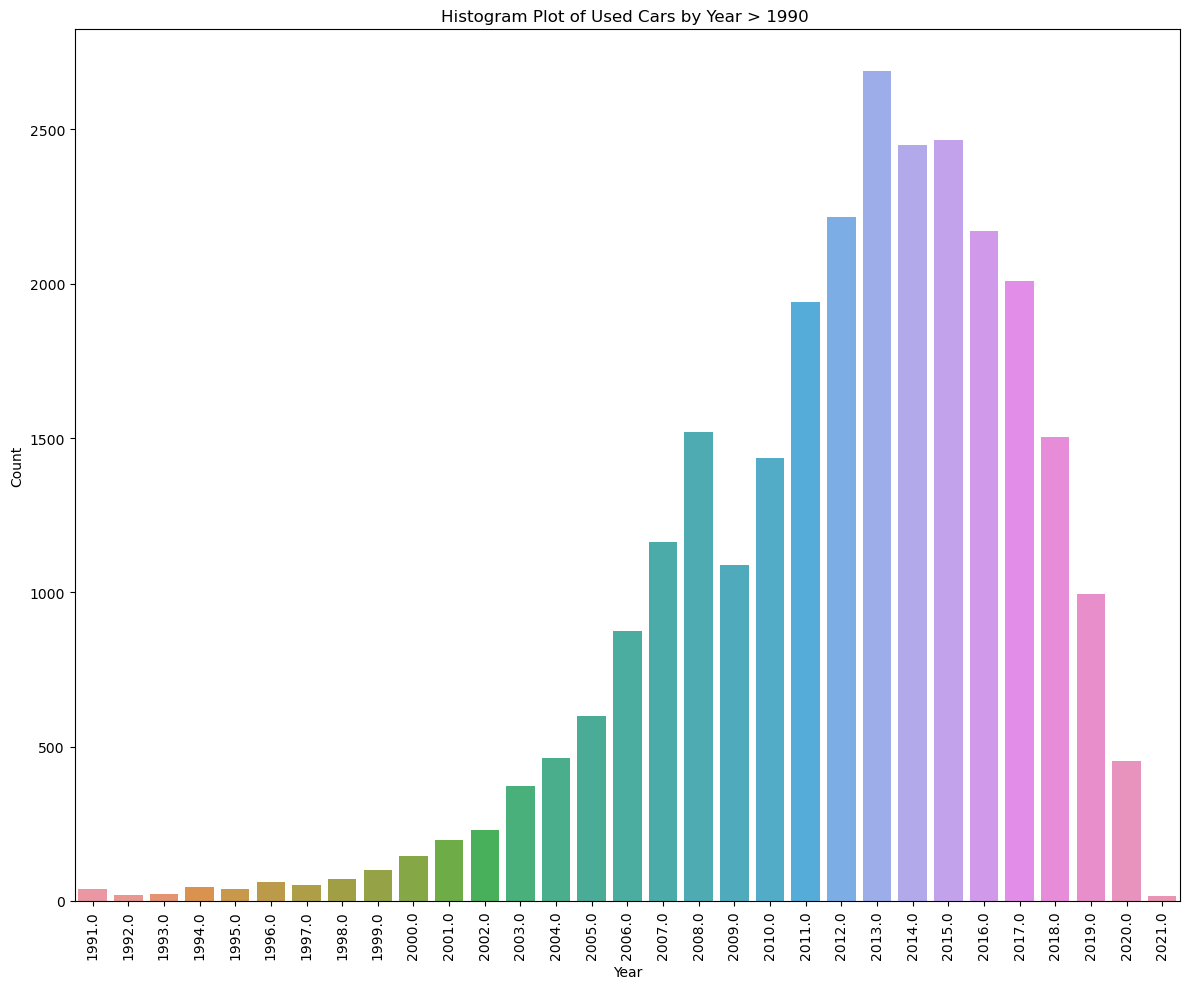

In [69]:
# Plot the number of used car counts by year after filtering records to > 1900

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='year', data=new_car_data_1990_df , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Year > 1990 ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Year")
ax.set_ylabel("Count")

plt.show()

In [70]:
# Create a model using Odometer, Year, fuel_diesel, drive_4wd and size_full-size for Price Prediction
# These features are the ones that have a positive correlation with car price
X7 = new_car_data_1990_df[['odometer', 'year', 'fuel_diesel', 'drive_4wd', 'size_full-size']]
y7 = new_car_data_1990_df.price
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = 0.3, random_state = 0)
model7=LinearRegression(fit_intercept=False)
model7.fit(X7_train, y7_train)
print("Coefficient of the model: ",model7.coef_)
print("Intercept of the model: ", model7.intercept_)

#Let compute the predictions for the entire set of inputs
train7_predictions=model7.predict(X7_train)

#Compute Accuracy and RMSE to training model
score7 = model7.score(X7_train, y7_train)
print("Accuracy: ", round(score7*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y7_train,train7_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test7_predictions=model7.predict(X7_test)

# Compute Accuracy and RMSE to test model
score7 = model7.score(X7_test, y7_test)
print("Accuracy: ", round(score7*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y7_test,test7_predictions)), 2))

Coefficient of the model:  [-9.79393406e-02  1.05400863e+01  1.65377878e+04  5.88123006e+03
  5.50763744e+03]
Intercept of the model:  0.0
Accuracy:  47.52
RMSE:      9089.08
Accuracy:  48.26
RMSE:      8970.29


In [71]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

model7R = Ridge(alpha=1e-2).fit(X7_train, y7_train)
model7R.score(X7_test, y7_test)

0.5613509556616727

In [72]:
#  permutation_importance function to probe which features are most predictive
r7 = permutation_importance(model7R, X7_test, y7_test, n_repeats=30, random_state=0)
# mean values for permutation_importance
perm_df7 = pd.Series(r7.importances_mean, index=X7_test.columns).sort_values(ascending=False)
perm_df7

fuel_diesel       0.318646
year              0.208185
odometer          0.204708
drive_4wd         0.088106
size_full-size    0.085358
dtype: float64

Text(0.5, 0, 'Car Features')

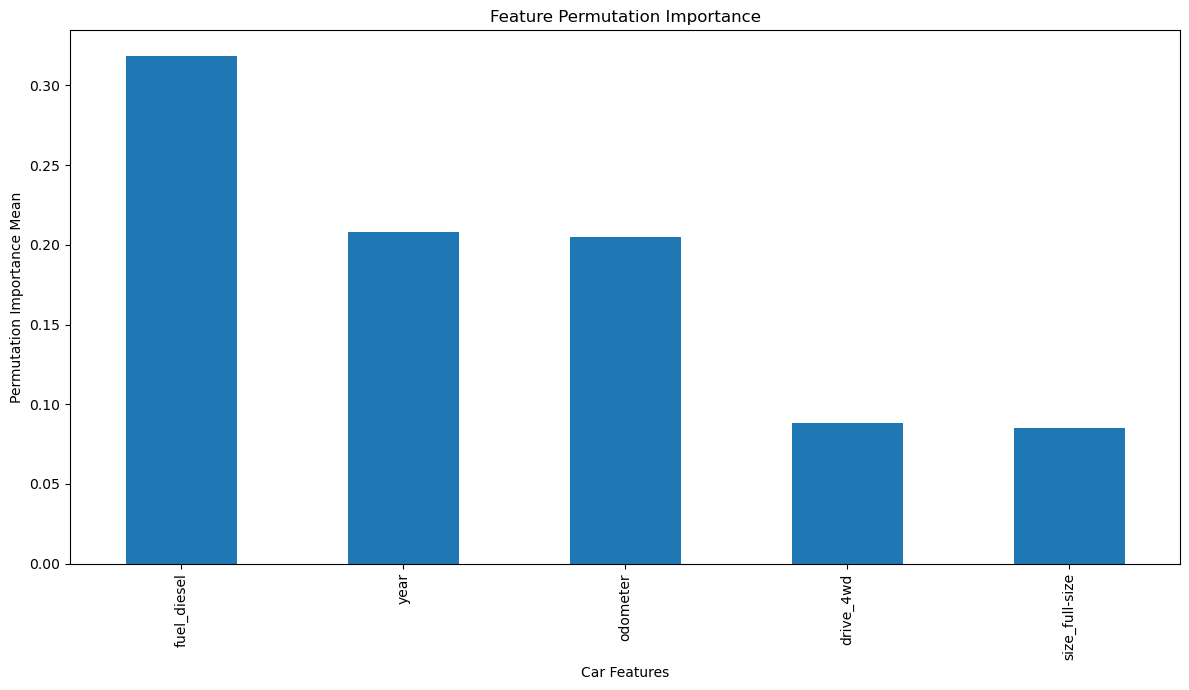

In [73]:
# Bar chart plot of the mean values for permutation_importance
plt.figure(figsize =(12, 7))
perm_df7.plot.bar(x=X7_test.columns, y=r7.importances_mean)

plt.title("Feature Permutation Importance")
plt.ylabel("Permutation Importance Mean")
plt.xlabel("Car Features")

With regards to high quality model based on the dataset provided, Model6 and Model7 are the recommended models.

When we analyze the importance of feature selection based on the trained model, we observe the following order

Model6 - Diesel Fuel, Odometer, Four Wheel Drive, Full Size and Year
Model7 - Diesel Fuel, Year, Odometer, Four Wheel Drive and Full Size

# Conclusion
When we analyzed the factors contributing to the used car price in the application, we observed the following order of importance:

1. Diesel Fuel

2. Year

3. Odometer

4. Four Wheel Drive

5 Full Size
